This tutorial guides you on how to train a logistic regression based on the Titanic dataset. Usually, a logistic regression model is used as a baseline compared to other models.|

In [0]:
!pip install -q tf-nightly
!pip install -q sklearn

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import requests
import os
import sys

print("Tensorflow Version: {}".format(tf.__version__))
print("Eager Mode: {}".format(tf.executing_eagerly()))
print("GPU {} available".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200113
Eager Mode: True
GPU is available


# Data Preprocessing

In [0]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## Exploring Data|

In [3]:
dftrain.head(3)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y


In [4]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


There are 627 and 264 rows(examples) in the train and test dataset respectively.

In [5]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

Most passengers were 20~30 years old.

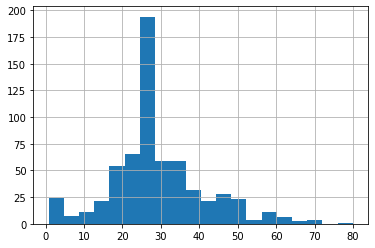

In [6]:
dftrain["age"].hist(bins=20)

Most passengers were male.

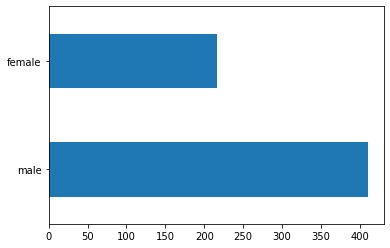

In [7]:
dftrain["sex"].value_counts().plot(kind='barh')

Most passengers were in the Third class.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  """Entry point for launching an IPython kernel.


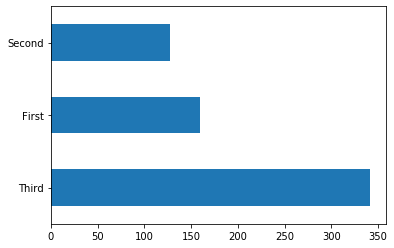

In [8]:
dftrain["class"].value_counts().plot('barh')

The female survived rate is higher than the male one.

Text(0.5, 0, '% survive')

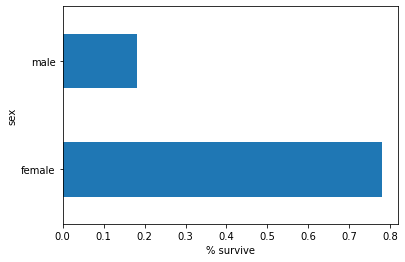

In [9]:
pd.concat([dftrain, y_train], axis=1).groupby('sex')["survived"].mean().plot(kind="barh").set_xlabel('% survive')

## Feature Engineering

The Estimators support a data architecture `feature columns` that describe how the model should interpret each of the input features in a row.

Selecting and transforming the features benefit the model training in some ML models. A `feature column` can be simply one of the raw inputs in the original Python `dictionary` data type (**base feature column**) or can be transformed or derived from multiple columns into a new column (**derived feature column**).

The `feature columns` basically are composed of two data types, a numeric data type, and a categorical data type. It also provides lots of built-in feature engineering capabilities like on-hot encoding, normalization, and bucketization, etc.

### Base Feature Columns

In [0]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [0]:
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(
      key=feature_name, vocabulary_list=vocabulary))
  
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(key=feature_name, dtype=tf.float32))

Next, you are going to create an `input_fn` function that feeds the dataset and the label into the model during training, evaluating. Here we recommended accessing the dataset and the label via the `tf.data.Dataset` APIs. 

In [0]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  """Returns a input_fn method not a tf.data.Dataset."""
  def input_fn():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    ds = ds.repeat(num_epochs)
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)
    return ds
  return input_fn

In [0]:
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

You can inspect the dataset.

In [14]:
_ds = make_input_fn(dftrain, y_train, batch_size=5)()
_ds

<BatchDataset shapes: ({sex: (None,), age: (None,), n_siblings_spouses: (None,), parch: (None,), fare: (None,), class: (None,), deck: (None,), embark_town: (None,), alone: (None,)}, (None,)), types: ({sex: tf.string, age: tf.float64, n_siblings_spouses: tf.int32, parch: tf.int32, fare: tf.float64, class: tf.string, deck: tf.string, embark_town: tf.string, alone: tf.string}, tf.int32)>

In [15]:
for feats, labels in _ds.take(1):
  print("Feature keys: {}".format(feats.keys()), sep='\n\n')
  print("Some values on key class: {}".format(feats["class"], sep='\n\n'))
  print("A batch of Labels: {}".format(labels))

Feature keys: dict_keys(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone'])
Some values on key class: [b'Second' b'First' b'Third' b'Second' b'Third']
A batch of Labels: [1 1 1 0 0]


You can also inspect the value via the `tf.keras.layers.DenseFeatures` API. This API can also be a part of the Keras model.

In [16]:
_inspect_feat = feature_columns[7]  # the age column
_age = tf.keras.layers.DenseFeatures([_inspect_feat])(feats)
_age.numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[ 3.],
       [49.],
       [28.],
       [30.],
       [22.]], dtype=float32)

However the `tf.keras.layers.Densefeatures` layer only accepts dense features (e.g. numeric values), you have to convert the categorical columns into an indictor one first.

In [17]:
_gender_column = feature_columns[0]
_gender = tf.keras.layers.DenseFeatures(tf.feature_column.indicator_column(_gender_column))
_batch_gender = _gender(feats)
_batch_gender.numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

You can now train a linear estimator.

In [27]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7462121, 'accuracy_baseline': 0.625, 'auc': 0.82966024, 'auc_precision_recall': 0.7856156, 'average_loss': 0.4920278, 'label/mean': 0.375, 'loss': 0.4853388, 'precision': 0.63793105, 'prediction/mean': 0.43950275, 'recall': 0.74747473, 'global_step': 196}


### Derived Feature Columns

To improve the performance of a baseline model, let's take a look at the dataset. The data imbalance was shown between male and female, and the age as well. The `tf.feature_column.crossed_column` API provides to take specific multi-column as the crossed feature. Here we use both age and sex as the crossed features.

In [25]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)
age_x_gender

CrossedColumn(keys=('age', 'sex'), hash_bucket_size=100, hash_key=None)

In [28]:
dervied_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(
    feature_columns=feature_columns + dervied_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.77272725, 'accuracy_baseline': 0.625, 'auc': 0.8519743, 'auc_precision_recall': 0.78388464, 'average_loss': 0.4634098, 'label/mean': 0.375, 'loss': 0.4538852, 'precision': 0.70526314, 'prediction/mean': 0.35888952, 'recall': 0.67676765, 'global_step': 196}


Predict the data.

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpclzxeoir/model.ckpt-196
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


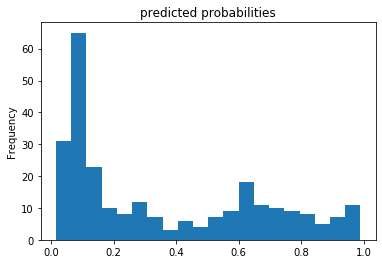

In [30]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [0]:
from sklearn.metrics import roc_curve

(0, 1.05)

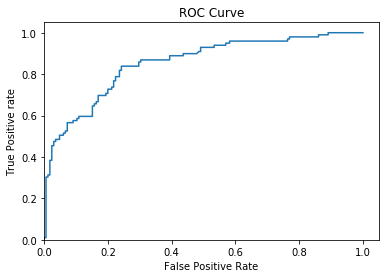

In [32]:
fpr, tpr, _ = roc_curve(y_eval, probs)

plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.xlim(0,)
plt.ylim(0,)